In [1]:
import time
import langid
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
WORDBAGS_JSON = 'data/WordbagsBuckets.json'
LABELS_JSON = 'data/WordbagsLabels.json'

# Site clustering

While importing the data we should divide it into english and polish cathegories, thus why we again utilise the langid library and create _pl and _en corpuses.

We use TfidVectorizer with idf option which corresponds to TF-IDF featre weighting, and sublinear_tf flag allows us to smooth the weights, making the difference between 20 and 22 occurences of a word less important than 0 and 2. We limit it to include only words that make less than 50% of documents and appear at least twice.

In order to achieve the goal of clustering the sites we have to decide on the clustering alghoritm. I choose to stick to the well known KMeans clsutering, as it is simple, general-purpose tool suited well for a small number of clusters. Additionally we don't need the feature of dynamically choosing that number, a feature offered by few other alghoritms like OPTICS. 

It would be benefitial to perform a singular value decomposition on our feature matrix before stuffing it into KMeans alghoritm, as it improves its performance for high-dimensional data like ours, with over 10000 word-features for only 27 sites. We could normalise them, but the work of reweighting the veactors' features has been already done by sublinear_tf flag. 

We display the results minding the decomposition we made earlier has to be rolled back.

In [2]:
df = pd.read_json(WORDBAGS_JSON)
df = df[df['wordbag'] != ''].copy()

# Language tagging
df['pl'] = [False if (langid.classify(' '.join(df.iloc[i]['wordbag'].split()[:50]))[0] == 'en') else True
             for i in range(0, len(df.values))] 

corpus_pl = [row.wordbag for _,row in df[df['pl']].iterrows()]
sites_pl = df[df['pl']]['netloc'].values

corpus_en = [row.wordbag for _,row in df[~df['pl']].iterrows()]
sites_en = df[~df['pl']]['netloc'].values

In [3]:
np.random.seed(2137)
n_clusters = 4

# Vectorisation of imputs
vectorizer_pl = TfidfVectorizer(sublinear_tf=True, max_df=0.4, min_df=2, use_idf=True)
X_pl = vectorizer_pl.fit_transform(corpus_pl)

vectorizer_en = TfidfVectorizer(sublinear_tf=True, max_df=0.4, min_df=2, use_idf=True)
X_en = vectorizer_en.fit_transform(corpus_en)

In [4]:
# Normalisation of matrices
svd_pl = TruncatedSVD(100)
X_pl = svd_pl.fit_transform(X_pl)

svd_en = TruncatedSVD(100)
X_en = svd_en.fit_transform(X_en)

In [ ]:
km_pl = KMeans(
        n_clusters=n_clusters,
        init="k-means++",
        max_iter=100, #max_iter and n_init has been selected by manual trials and observaitons.
        n_init=30
)
t0 = time.time()
km_pl.fit(X_pl)

terms_pl = vectorizer_pl.get_feature_names_out()
original_space_centroids_pl = svd_pl.inverse_transform(km_pl.cluster_centers_)
order_centroids_pl = original_space_centroids_pl.argsort()[:, ::-1]


km_en = KMeans(
        n_clusters=n_clusters,
        init="k-means++",
        max_iter=100,
        n_init=30
)
km_en.fit(X_en)

terms_en = vectorizer_en.get_feature_names_out()
original_space_centroids_en = svd_en.inverse_transform(km_en.cluster_centers_)
order_centroids_en = original_space_centroids_en.argsort()[:, ::-1]

## Effects

Below written are the effects of clustering on _pl and _en categorised websites along with 10 most significant word for each class.

Repeated tests proved, that limiting oneself to 2 groups - presumeably the "laisure" and "work" kinds of sites - makes the predictions less accurate than our intuition would suggest. 
Fortunately, the third one groups only the outlook domain, which itself fits to neither of those two.

In [6]:
for i in range(n_clusters):
    print(f'Cluster {i} ', end='')
    print({sites_pl[l] for l in range(len(sites_pl)) if km_pl.labels_[l] == i}, end=':\n ')
    for k in order_centroids_pl[i, :10]:
        print(f' {terms_pl[k]} ', end='')
    print()

Cluster 0 {'www.linkedin.com', 'coub.com', 'docs.google.com', 'www.facebook.com', 'pl.wikipedia.org', 'sjp.pwn.pl', 'sjp.pl', 'translate.google.pl', 'pandas.pydata.org', 'www.youtube.com', 'synonim.net', 'www.sokmarket.com.tr', 'www.instagram.com', 'soundcloud.com', 'nofluffjobs.com', 'www.cloudskillsboost.google', 'im.uj.edu.pl'}:
  cooki  spersonalizować  adr  wykorzystywać  için  chwila  size  być  daha  profil 
Cluster 1 {'bdl.stat.gov.pl', 'api.stat.gov.pl', 'stat.gov.pl', 'login.uj.edu.pl', 'www.usosweb.uj.edu.pl'}:
  urząd  wzgląd  zablokować  statystyczny  kontakt  uniwersytecki  jagielloński  statystyka  rejestracja  baza 
Cluster 2 {'outlook.office365.com', 'outlook.office.com'}:
  ponownie  spróbować  warunki  base  odświeżyć  error  wystąpić  date  abl  spersonalizować 
Cluster 3 {'drive.google.com', 'app.erasmusplusols.eu', 'accounts.google.com'}:
  magyar  ελληνικά  eesti  български  hrvatski  latviešu  slovenščina  slovenčina  dansk  svenska 


In [7]:
for i in range(n_clusters):
    print(f'Cluster {i} ', end='')
    print({sites_en[l] for l in range(len(sites_en)) if km_en.labels_[l] == i}, end=':\n ')
    for k in order_centroids_en[i, :10]:
        print(f' {terms_en[k]} ', end='')
    print()

Cluster 0 {'github.com', 'www.geeksforgeeks.org', 'stackoverflow.com', 'en.wikipedia.org', 'www.postgresql.org', 'www.w3schools.com', 'math.stackexchange.com', 'www.reddit.com', 'www.kaggle.com'}:
  ourterm  schema  kaggl  danych  entiti  motion  copyright  kumar  dark  dane 
Cluster 1 {'www.gradescope.com'}:
  grade  courtesi  texttt  fring  latch  export  invest  kreb  instructor  regrad 
Cluster 2 {'www.roblox.com', 'www.overleaf.com', 'www.coursera.org'}:
  feder  universidad  overleaf  republ  institut  serviceappli  island  consent  beamer  california 
Cluster 3 {'odtuclass2021f.metu.edu.tr'}:
  athttp  semest  archiv  cooper  abasi  abbrevi  tylko  danych  raspberri  polityka 


## Averaging
The outcome is often not identical for each execution, so in order to obtain a statistical image we'll average out several executions of clustering before writing down the classification. The outcome of it will be a family set of sets (each iteration produces 8 sets separating each corpus to 4 disjoint sets), so we'll calculate the ratios of "sharing the same group" between sites, which can be bautifully expressed via a 2d heatmap.

In [8]:
def ratioing(a, b, the_list):
    count = 0
    for grouping in the_list:
        for x in grouping:
            if a in x and b in x:
                count += 1
    return count/len(the_list)

In [9]:
n_clusters = 4
iters = 10

vectorizer_pl = TfidfVectorizer(sublinear_tf=True, max_df=0.4, min_df=2, use_idf=True)
X_pl = vectorizer_pl.fit_transform(corpus_pl)
vectorizer_en = TfidfVectorizer(sublinear_tf=True, max_df=0.4, min_df=2, use_idf=True)
X_en = vectorizer_en.fit_transform(corpus_en)

svd_pl = TruncatedSVD(100)
X_pl = svd_pl.fit_transform(X_pl)
svd_en = TruncatedSVD(100)
X_en = svd_en.fit_transform(X_en) 

list_pl = []
list_en = []


for i in range(iters):
    grouping_pl = []
    grouping_en = []
    
    km_pl = KMeans(
            n_clusters=n_clusters,
            init="k-means++",
            max_iter=100,
            n_init=30
    )
    km_pl.fit(X_pl)
    
    km_en = KMeans(
            n_clusters=n_clusters,
            init="k-means++",
            max_iter=100,
            n_init=30
    )
    km_en.fit(X_en)
    
    for k in range(n_clusters):
        set_pl = {l for l in range(len(sites_pl)) if km_pl.labels_[l] == k}
        grouping_pl.append(set_pl)
        
        set_en = {l for l in range(len(sites_en)) if km_en.labels_[l] == k}
        grouping_en.append(set_en)
        
    list_pl.append(grouping_pl)
    list_en.append(grouping_en)

ratios_pl = [[ratioing(k, l, list_pl) for l in range(len(sites_pl))] for k in range(len(sites_pl))]
ratios_en = [[ratioing(k, l, list_en) for l in range(len(sites_en))] for k in range(len(sites_en))]

## Visualisation

We bring the mentioned matrix to life. The more saturated the cell, the more often a domain pair happen to be coupled across multiple clusterings. The value inside a cell is equal to the proportion of number of sets these two sites happen to be togather to the number of all gropings.

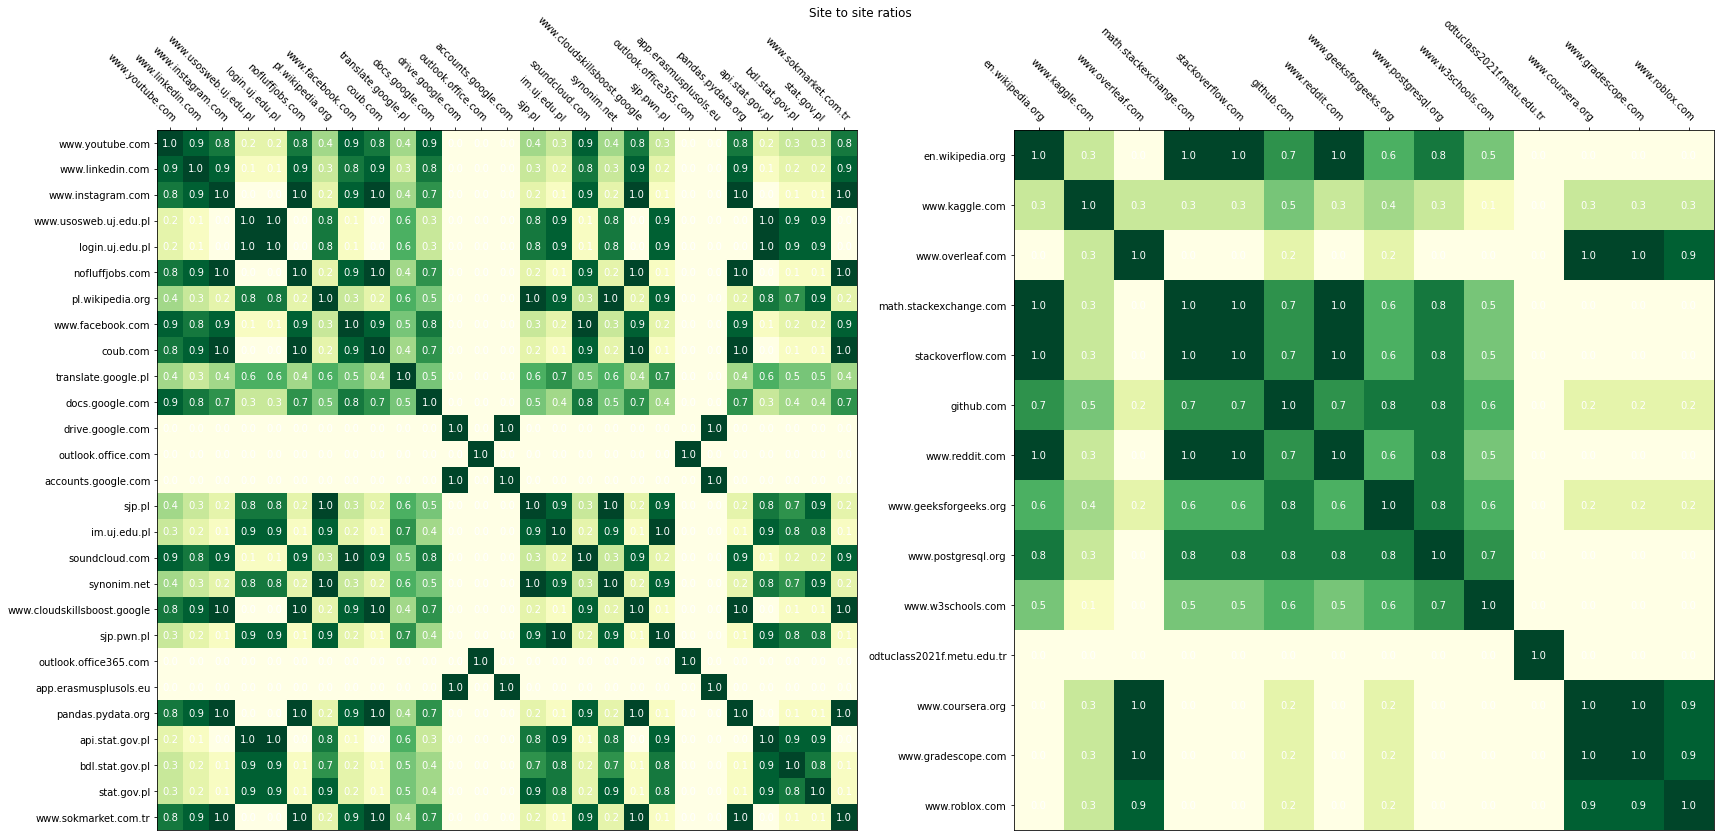

In [10]:
fig, (ax_pl, ax_en) = plt.subplots(1,2, figsize=(24, 12))
im_pl = ax_pl.imshow(ratios_pl, cmap = 'YlGn')

ax_pl.set_xticks(np.arange(len(ratios_pl)))
ax_pl.set_yticks(np.arange(len(ratios_pl)))
ax_pl.set_xticklabels(sites_pl)
ax_pl.set_yticklabels(sites_pl)

ax_pl.tick_params(top=True, bottom=False,
                  labeltop=True, labelbottom=False)
plt.setp(ax_pl.get_xticklabels(), rotation=-45, ha='right', rotation_mode='anchor')

    
for i in range(len(ratios_pl)):
    for j in range(len(ratios_pl)):
        text_pl = ax_pl.text(j, i, ratios_pl[i][j], ha='center', va='center', color='w')
        
        
im_en = ax_en.imshow(ratios_en, cmap = 'YlGn')

ax_en.set_xticks(np.arange(len(ratios_en)))
ax_en.set_yticks(np.arange(len(ratios_en)))
ax_en.set_xticklabels(sites_en)
ax_en.set_yticklabels(sites_en)

ax_en.tick_params(top=True, bottom=False,
                  labeltop=True, labelbottom=False)
plt.setp(ax_en.get_xticklabels(), rotation=-45, ha='right', rotation_mode='anchor')

    
for i in range(len(ratios_en)):
    for j in range(len(ratios_en)):
        text_en = ax_en.text(j, i, ratios_en[i][j], ha='center', va='center', color='w')        
        
fig.suptitle('Site to site ratios')
fig.tight_layout()
plt.show()


## Final classification

We can point out several groupings, among which not all are intuitional and serve our purpose. For example, somehow the erasmusplusOLS site has almost perfect correlation with accounts.google.com.

### Selecting the representative

We will decide on grouping by selecting one from all of the groupings done so far, judging by how much it fits our correlation-like matrices. The method of judgement will be simple: for each set in each grouping we calculate a sum of ratios between each pair within it. Consider this dummy example on two sets:

A = {sjp.pwn.pl, sjp.pl, synonim.net} and B = {sjp.pwn.pl, bdl.stat.gov.pl, synonim.net}. We can read following correlations: 
- sjp.pwn.pl - sjp.pl: 0.93
- sjp.pl - synonim.net: 0.77
- sjp.pwn.pl - synonim.net: 0.8
- sjp.pwn.pl - bdl.stat.gov.pl: 0.72
- bdl.stat.gov.pl - synonim.net: 0.66

The scores for A and B are accordingly 0.93 + 0.77 + 0.8 = 2.5 and 0.8 + 0.72 + 0.66 = 2.18

With our metric, the A fits the _pl matrix better than B. We later sum all the scores for each groupings to compare whole groupings.

In [1]:
def scoring(the_list, the_ratios):
    """
    We compute the score and the index of best grouping for a given list of groupings and ratio matrix.
    
    """
    
    scores = []
    for grouping in the_list:
        grouping_score = 0
        for x in grouping:
            x_score = 0
            for y in itertools.combinations(x,2):
                x_score += the_ratios[y[0]][y[1]]
            grouping_score += x_score
        scores.append(grouping_score)
    top_score = max(scores)
    top_index = scores.index(top_score)
    return (top_index, top_score)

In [12]:
top_pl = scoring(list_pl, ratios_pl)
top_en = scoring(list_en, ratios_en)

for i in range(n_clusters):
    print(f'Cluster {i} ', end='')
    print({sites_pl[l] for l in list_pl[top_pl[0]][i]}, end='\n ')
print()
for i in range(n_clusters):
    print(f'Cluster {i} ', end='')
    print({sites_en[l] for l in list_en[top_en[0]][i]}, end='\n ')

Cluster 0 {'api.stat.gov.pl', 'bdl.stat.gov.pl', 'pl.wikipedia.org', 'sjp.pwn.pl', 'sjp.pl', 'stat.gov.pl', 'login.uj.edu.pl', 'translate.google.pl', 'synonim.net', 'www.usosweb.uj.edu.pl', 'im.uj.edu.pl'}
 Cluster 1 {'outlook.office365.com', 'outlook.office.com'}
 Cluster 2 {'drive.google.com', 'app.erasmusplusols.eu', 'accounts.google.com'}
 Cluster 3 {'www.linkedin.com', 'coub.com', 'docs.google.com', 'www.facebook.com', 'pandas.pydata.org', 'www.youtube.com', 'www.instagram.com', 'soundcloud.com', 'nofluffjobs.com', 'www.cloudskillsboost.google', 'www.sokmarket.com.tr'}
 
Cluster 0 {'www.kaggle.com'}
 Cluster 1 {'github.com', 'www.geeksforgeeks.org', 'stackoverflow.com', 'en.wikipedia.org', 'www.postgresql.org', 'www.w3schools.com', 'math.stackexchange.com', 'www.reddit.com'}
 Cluster 2 {'odtuclass2021f.metu.edu.tr'}
 Cluster 3 {'www.roblox.com', 'www.gradescope.com', 'www.overleaf.com', 'www.coursera.org'}
 

### Writing down the labels

The selected classifications aren't perfect. The amount of groups and n_init parameter has been configured to match the anticipated clusters. With the results written out for a random seed set for 2137 we achieve the following clusters:

Polish sites:

0. {'api.stat.gov.pl', 'bdl.stat.gov.pl', 'pl.wikipedia.org', 'sjp.pwn.pl', 'sjp.pl', 'stat.gov.pl',<br>
    'login.uj.edu.pl', 'translate.google.pl', 'synonim.net', 'www.usosweb.uj.edu.pl', 'im.uj.edu.pl'}
1. {'outlook.office365.com', 'outlook.office.com'}
2. {'drive.google.com', 'app.erasmusplusols.eu', 'accounts.google.com'}
3. {'www.linkedin.com', 'coub.com', 'docs.google.com', 'www.facebook.com', 'pandas.pydata.org', <br>
    'www.youtube.com', 'www.instagram.com', 'soundcloud.com', 'nofluffjobs.com', 'www.cloudskillsboost.google', 'www.sokmarket.com.tr'}

English sites:

0. {'www.kaggle.com'}
1. {'github.com', 'www.geeksforgeeks.org', 'stackoverflow.com', 'en.wikipedia.org', 'www.postgresql.org', 'www.w3schools.com', 'math.stackexchange.com', 'www.reddit.com'}
2. {'odtuclass2021f.metu.edu.tr'}
3. {'www.roblox.com', 'www.gradescope.com', 'www.overleaf.com', 'www.coursera.org'}

I decided to tag the sites accordingly:

- Laisure: 3 from _pl, 3 from _en
- Learning: 0 from _pl, 0 and 1 from _en
- Miscellaneous: 2 and 1 from _pl, 2 from _en

In [ ]:
df_labels = df.loc[:, ['netloc']].copy()

def select(netloc):
    """
    We select the sitetype for each grouping in line with our assumptions.
    """
    
    if (netloc in {sites_pl[l] for l in list_pl[top_pl[0]][3]}) or \
       (netloc in {sites_en[l] for l in list_en[top_en[0]][3]}):
        return 'Laisure'
    
    if (netloc in {sites_pl[l] for l in list_pl[top_pl[0]][0]}) or \
       (netloc in {sites_en[l] for l in list_en[top_en[0]][0]}) or \
       (netloc in {sites_en[l] for l in list_en[top_en[0]][1]}):
        return 'Learning'

    if (netloc in {sites_pl[l] for l in list_pl[top_pl[0]][1]}) or \
       (netloc in {sites_pl[l] for l in list_pl[top_pl[0]][2]}) or \
       (netloc in {sites_en[l] for l in list_en[top_en[0]][2]}):
        return 'Miscellaneous'    

df_labels['label'] = df_labels['netloc'].apply(select)

In [14]:
df_labels

,netloc,label
0,www.youtube.com,Laisure
2,www.linkedin.com,Laisure
3,www.instagram.com,Laisure
4,www.usosweb.uj.edu.pl,Learning
5,login.uj.edu.pl,Learning
6,en.wikipedia.org,Learning
7,nofluffjobs.com,Laisure
8,www.kaggle.com,Learning
9,www.overleaf.com,Laisure
10,pl.wikipedia.org,Learning


#### Exporting the labels

In [15]:
df_labels.to_json(LABELS_JSON)